In [1]:
import pickle
import matplotlib.pyplot as plt
import utils
from utils import get_data_from_dropsonde
from LoopTimer import LoopTimer
from inversion_heights import get_data_from_flight, get_GOES_cloud_top_height  # calc_zi_from_sounding, calc_decoupling_from_sounding
from met_utils import calc_zi_from_sounding, calc_decoupling_from_sounding
import glob
import os
import numpy as np
import warnings
import lagrangian_case as lc
import datetime as dt
from matplotlib import gridspec, rc

%load_ext autoreload
%autoreload 2

In [6]:
def get_GOES_cloud_fraction(lat, lon, time, degrees):
    """
    Get the GOES cloud fraction value from to the space/time, filtering for high cloud. Use GOES flight files
    """
    variable_list = ['cloud_phase', 'cloud_top_height', 'cloud_top_temperature']
    data = utils.get_GOES_data(variable_list, lat=lat, lon=lon, time=time, degree=degrees)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warm_low_cloud = (
                        (data['cloud_phase'] == 1) &
                        (data['cloud_top_height'] < 4.) &
                        (data['cloud_top_temperature'] > 273.15))
        warm_low_cloud_fraction = np.sum(warm_low_cloud) /\
                                float(np.sum((data['cloud_phase'] == 4) | warm_low_cloud))
    return warm_low_cloud_fraction    

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    path = r'/home/disk/eos4/jkcm/Data/CSET/LookupTable_all_flights.xls'
    flight = utils.read_CSET_Lookup_Table(path, 
                                       rf_num='all', 
                                       legs=['d', 'k'],
                                       variables=['Date', 'ST', 'ET'])
    start_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
                   zip(flight['Date']['values'], flight['ST']['values'])])
    end_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
                 zip(flight['Date']['values'], flight['ET']['values'])])
    sounding_times = list(zip(flight['rf'], start_times, end_times))

    # %% read in data    
    # get flight info for each sounding
    var_list = ['GGLAT', 'GGLON', 'GGALT', 'RHUM', 'ATX', 'MR', 'THETAE', 'THETA', 'PSX', 'DPXC', 'PLWCC']
    soundings = []
    lt = LoopTimer(len(sounding_times))
    print("processing soundings...\n")
    for i in sounding_times:
        lt.update()
        soundings.append(get_data_from_flight(i[0], i[1], i[2], var_list))

    add_dropsondes = True
    if add_dropsondes:
        sondes = []
        sonde_files = glob.glob(os.path.join(utils.dropsonde_dir, "*.nc"))
        for f in sonde_files:
            sondes.append(get_data_from_dropsonde(f))

processing soundings...

100.00%      ETA 22:27:42      time left: 0 seconds       

In [22]:
    # %% calc inv and dec 
    # get inversion height estimates for each sounding
    heights = []
    for i, snd in enumerate(soundings):
        heights.append(calc_zi_from_sounding(snd))

    snd_heights = []
    for sonde in sondes:
        snd_heights.append(calc_zi_from_sounding(sonde))

    # get decoupling ests for each sounding
    decouplings = []
    lt = LoopTimer(len(soundings))
    print("processing decouplings...\n")
    for i, snd in enumerate(soundings):
        lt.update(i)
        decouplings.append(calc_decoupling_from_sounding(snd, get_jumps=False))

    snd_decouplings = []
    for sonde in sondes:
        snd_decouplings.append(calc_decoupling_from_sounding(sonde, usetheta=True, get_jumps=False))



#     heights, snd_heights, decouplings, snd_decouplings = []

#     for i, snd in enumerate(soundings):
#         inv_dec = calc_decoupling_and_zi_from_flight_data()
#         heights.append(calc_zi_from_sounding(snd))
    
    
#     for i, snd in enumerate(soundings)


    # %% get goes data
    percentiles = [50, 75, 90, 95]
    all_GOES_percentiles = {}
    lt = LoopTimer(len(heights + snd_heights)*len(percentiles))
    print("processing GOES CTH percentiles...\n")
    for percentile in percentiles:
        GOES_cth = []
        for i, hgt in enumerate((heights + snd_heights)):
            lt.update()
            goes_hgt = get_GOES_cloud_top_height(hgt['lat'], hgt['lon'], hgt['time'], percentile=percentile, degrees=1)
            GOES_cth.append(goes_hgt)
        all_GOES_percentiles[str(percentile)] = np.array(GOES_cth)

processing decouplings...

98.75%      ETA 15:26:04      time left: 0 seconds       processing GOES CTH percentiles...

100.00%      ETA 15:29:15      time left: 0 seconds       

In [24]:
    GOES_CF = []
    lt = LoopTimer(len(heights + snd_heights))
    print("processing GOES CF...]n")
    for i, hgt in enumerate((heights + snd_heights)):
        lt.update()
        cf = get_GOES_cloud_fraction(hgt['lat'], hgt['lon'], hgt['time'], degrees=2)
        GOES_CF.append(cf)

processing GOES CF...]n
100.00%      ETA 15:30:34      time left: 0 seconds       

In [25]:
source = np.concatenate((np.full_like(heights, fill_value='gv'), np.full_like(snd_heights, fill_value='sonde')))
all_heights = heights + snd_heights
all_decouplings = decouplings + snd_decouplings
all_soundings = soundings + sondes


zi_RHCB = np.empty_like(all_heights, dtype=float)
zi_Heff_bot = np.empty_like(zi_RHCB)
zi_Heff_top = np.empty_like(zi_RHCB)
zi_RH50 = np.empty_like(zi_RHCB)
lon_p = np.empty_like(zi_RHCB)
d_theta_e = np.empty_like(zi_RHCB)
d_theta_l = np.empty_like(zi_RHCB)
d_qt = np.empty_like(zi_RHCB)
alpha_thetae = np.empty_like(zi_RHCB)
alpha_thetal = np.empty_like(zi_RHCB)
alpha_qt = np.empty_like(zi_RHCB)
goes_cf = np.empty_like(zi_RHCB)
lats = np.empty_like(zi_RHCB)
lons = np.empty_like(zi_RHCB)
Heff_inv_flag = np.empty_like(zi_RHCB)
RHCB_inv_flag = np.empty_like(zi_RHCB)
time = np.empty_like(zi_RHCB, dtype='object')

for i, (hgt, dec) in enumerate(zip(all_heights, all_decouplings)):
    zi_RHCB[i] = hgt['RHCB']['z']
    time[i] = hgt['time']
    RHCB_inv_flag[i] = hgt['RHCB']['inversion']
    zi_RH50[i] = hgt['RH50']['z']
    zi_Heff_bot[i] = hgt['Heff']['z_bot']
    zi_Heff_top[i] = hgt['Heff']['z_top']
    Heff_inv_flag[i] = hgt['Heff']['inversion']
    lon_p[i] = hgt['lon_p']
    d_theta_e[i] = dec['d_theta_e']
    d_theta_l[i] = dec['d_theta_l']
    d_qt[i] = dec['d_qt']
    alpha_thetae[i] = dec['alpha_thetae']
    alpha_thetal[i] = dec['alpha_thetal']
    alpha_qt[i] = dec['alpha_qt']
    lats[i] = hgt['lat']
    lons[i] = hgt['lon']

x = np.argsort(lon_p)

to_exclude = [151]
x = [i for i in x if i not in to_exclude]
zi_RHCB = zi_RHCB[x]
zi_Heff_bot = zi_Heff_bot[x]
zi_Heff_top = zi_Heff_top[x]
zi_RH50 = zi_RH50[x]
lon_p = lon_p[x]
d_theta_e = d_theta_e[x]
d_theta_l = d_theta_l[x]
d_qt = d_qt[x]
source = source[x]
time = time[x]
RHCB_inv_flag = RHCB_inv_flag[x]
Heff_inv_flag = Heff_inv_flag[x]
gv_i = source == 'gv'
labs = np.argsort(x)
alpha_thetae = alpha_thetae[x]
alpha_thetal = alpha_thetal[x]
alpha_qt = alpha_qt[x]
lons = lons[x]
lats = lats[x]

GOES_sorted = {}
for k, v in all_GOES_percentiles.items():
    GOES_sorted[k] = v[x]
    
GOES_CF_sorted = np.array(GOES_CF)[x]

In [26]:
# save_dict = {"lon_prime": lon_p,
#              "date": time,                 
#              "Heffter_inversion_base": zi_Heff_bot,
#              "Heffter_inversion_top": zi_Heff_top,
#              "Heffter_inversion_flag": Heff_inv_flag,
#              "RelHum_inversion_base": zi_RHCB,
#              "RHCV_inversion_flag": RHCB_inv_flag,
#              "d_theta": d_theta_l,
#              "d_q": d_qt,
#              "source": source,
#              "lat": lats,
#              "lon": lons,
#              "GOES_CF": GOES_CF_sorted}

# savefile = r"/home/disk/eos4/jkcm/Data/CSET/Python/inversion_and_decoupling.pickle"
# with open(savefile, 'wb') as f:
#    pickle.dump(save_dict, f)


NameError: name 'RF06_i' is not defined

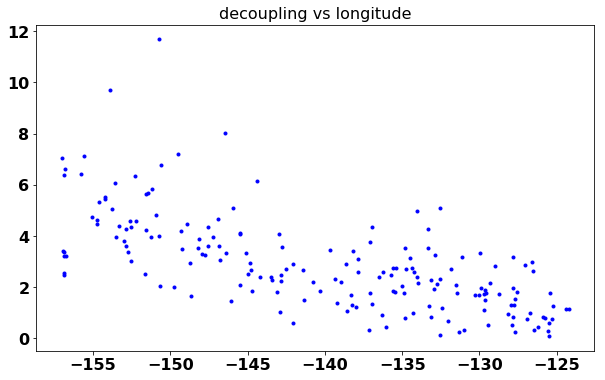

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('decoupling vs longitude')
ax.plot(lon_p, -d_qt, '.', c='b', label='all GV+dropsondes')
ax.plot(lon_p[RF06_i], -d_qt[RF06_i], '.', c='r', label='RF06')
# ax.plot(lon_p[~gv_i], -d_qt[~gv_i], '.', c='r', label='dropsondes (q_v only)')

# sc = ax.scatter(lon_p[gv_i], -d_qt[gv_i], marker='x', c=GOES_CF_sorted[gv_i], label='GV soundings', cmap='rainbow_r')

# sc = ax.scatter(lon_p[gv_i], -d_qt[gv_i], marker='x', c=GOES_CF_sorted[gv_i], label='GV soundings', cmap='rainbow_r')
# sc = ax.scatter(lon_p[~gv_i], -d_qt[~gv_i], marker='o', c=GOES_CF_sorted[~gv_i], label='dropsondes (q_v only)', cmap='rainbow_r')
ax.set_xlabel('lon-prime (deg)')
ax.set_ylabel('d_q (g/kg)')
ax.axhline(0.5, ls='--', label='Jones et al decoupling threshold')
plt.colorbar(sc, label='GOES warm low cloud fraction')
ax.legend()
# fig.savefig("/home/disk/p/jkcm/plots/lagrangian_paper_figures/dec_vs_lon_with_cf.png")

In [28]:
data = pickle.load(open(r"/home/disk/eos4/jkcm/Data/CSET/Python/inversion_and_decoupling.pickle", 'rb'))
ALC_RF06 = lc.AircraftCase("ALC_RF06BC/RF07AB")
ALC_RF10 = lc.AircraftCase("ALC_RF10A/RF11DE")

ValueError: could not parse input name

In [61]:
RF06_i = np.logical_and(data['date'] > ALC_RF06.outbound_start_time,
                        data['date'] < ALC_RF06.outbound_end_time)
RF07_i = np.logical_and(data['date'] > ALC_RF06.return_start_time-dt.timedelta(minutes=0),
                        data['date'] < ALC_RF06.return_end_time)
RF10_i = np.logical_and(data['date'] > ALC_RF10.outbound_start_time,
                        data['date'] < ALC_RF10.outbound_end_time)
RF11_i = np.logical_and(data['date'] > ALC_RF10.return_start_time,
                        data['date'] < ALC_RF10.return_end_time)

lon_p, d_qt = data['lon_prime'], data['d_q']

NameError: name 'RF06_i' is not defined

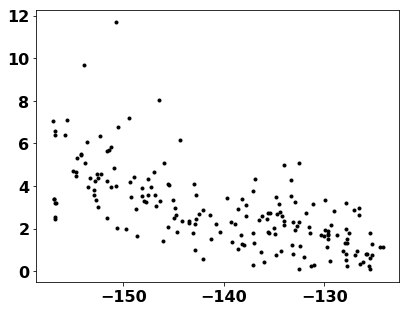

In [29]:
fig, ax = plt.subplots(figsize=(6.5,5))
# ax.set_title('decoupling vs longitude')
ax.plot(lon_p, -d_qt, '.', c='k', label='all GV+sondes')
ax.plot(lon_p[RF06_i], -d_qt[RF06_i], '.', c='olivedrab', ms=30, label='RF06')
ax.plot(lon_p[RF07_i], -d_qt[RF07_i], '*', c='olivedrab', ms=30, label='RF07')
ax.plot(lon_p[RF10_i], -d_qt[RF10_i], '.', c='orange', ms=30, label='RF10')
ax.plot(lon_p[RF11_i], -d_qt[RF11_i], '*', c='orange', ms=30, label='RF11')

# ax.plot(lon_p[~gv_i], -d_qt[~gv_i], '.', c='r', label='dropsondes (q_v only)')

# sc = ax.scatter(lon_p[gv_i], -d_qt[gv_i], marker='x', c=GOES_CF_sorted[gv_i], label='GV soundings', cmap='rainbow_r')

# sc = ax.scatter(lon_p[gv_i], -d_qt[gv_i], marker='x', c=GOES_CF_sorted[gv_i], label='GV soundings', cmap='rainbow_r')
# sc = ax.scatter(lon_p[~gv_i], -d_qt[~gv_i], marker='o', c=GOES_CF_sorted[~gv_i], label='dropsondes (q_v only)', cmap='rainbow_r')
ax.set_xlabel('lon-prime (deg)')
ax.set_ylabel('d_q (g/kg)')
ax.axhline(0.5, ls='--', label='Jones 2011')
# plt.colorbar(sc, label='GOES warm low cloud fraction')
ax.legend()
# fig.savefig("/home/disk/p/jkcm/plots/lagrangian_paper_figures/dec_vs_lon_with_cf.png",dpi=300, bbox_inches='tight')

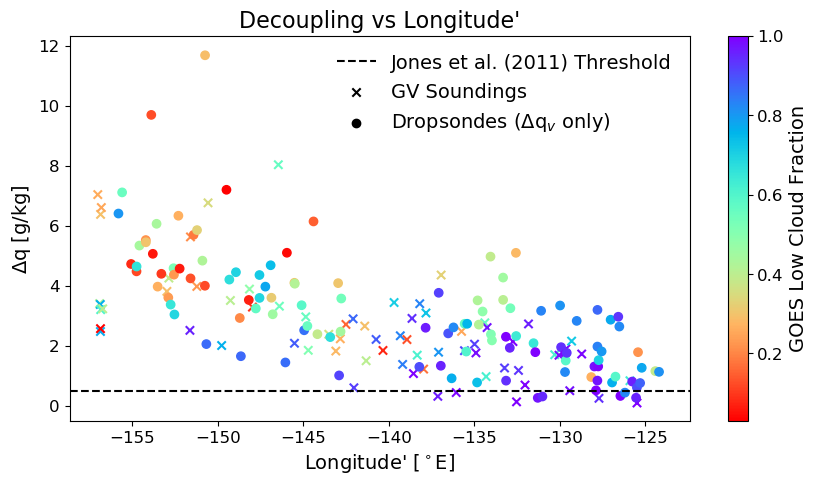

In [62]:

# font = {'family' : 'DejaVu Sans',
#         'weight' : 'bold',
#         'size'   : 16}
# rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=12)
ax.set_title('Decoupling vs Longitude\'', fontdict={'fontsize': 16})
sc = ax.scatter(lon_p[gv_i], -d_qt[gv_i], marker='x', c=GOES_CF_sorted[gv_i], label='GV Soundings', cmap='rainbow_r')
sc = ax.scatter(lon_p[~gv_i], -d_qt[~gv_i], marker='o', c=GOES_CF_sorted[~gv_i], label='Dropsondes ($\Delta$q$_v$ only)', cmap='rainbow_r')
ax.set_xlabel('Longitude\' [$^\circ$E]' , fontdict={'fontsize': 14})
ax.set_ylabel('$\Delta$q [g/kg]', fontdict={'fontsize': 14})
ax.axhline(0.5, ls='--', c='k', label='Jones et al. (2011) Threshold')
cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=12)
cb.set_label(label='GOES Low Cloud Fraction', fontsize=14)
leg = ax.legend(frameon=False, fontsize=14)
for i in leg.legendHandles:
    i.set_color('k')

fig.savefig("/home/disk/p/jkcm/plots/lagrangian_paper_figures/dec_vs_lon_with_cf_final.png",dpi=300, bbox_inches='tight')